In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#This code gets a disease hierarcy from DOID using OLS web service
#see https://www.ebi.ac.uk/ols4/swagger-ui/index.html#/
#look for ## to modify the code below

import requests
import pandas as pd

##replace the following file_name with your own
file_name='pneumonia_doid_icd2.txt'

cols = ['Group', 'Term', 'DOID', 'ICD10Code']
data=[]

##add one more disease to the following dict
ids={'Pneumonia':'DOID_552'} #kidney, lung disease
ont='doid'
root_url='http%253A%252F%252Fpurl.obolibrary.org%252Fobo%252F'
base_url='https://www.ebi.ac.uk/ols4/api/ontologies/'+ont+'/terms/'

for id in ids.keys():
  root_class=root_url+ids[id]
  search_url=base_url+root_class+'/hierarchicalDescendants?'
  print(search_url)
  flag=1
  page_size=100
  page_curr=0
  while flag==1:
    PARAMS = {'lang':'en','size':page_size,'page':page_curr}
    #sending get request and saving the response as response object
    r = requests.get(url = search_url, params = PARAMS)
    #extracting data in json format
    #find entities from ontologies
    data2 = r.json()
    terms=data2['_embedded']['terms']
    total_pages=data2['page']['totalPages']
    for t in terms:
      if 'annotation' in t.keys():
        if 'database_cross_reference' in t['annotation']:
          for d in t['annotation']['database_cross_reference']:
            if 'ICD10CM' in d:
              lbl=t['label']
              iri=t['iri']
              icd10_code=d.split(':')[1]
              #print(lbl,iri,icd10_code)
              data.append((id,lbl,iri,icd10_code))
    page_curr=page_curr+1
    if page_curr==total_pages: #total_pages or max
      flag=0
    else:
      flag=1
  #endwhile
#print(data)
df = pd.DataFrame(data, columns=cols)

f = open(file_name, 'w')
df.to_csv(f, sep='\t', encoding='utf-8', index=False, header=True)

f.close()
print('Done!')


https://www.ebi.ac.uk/ols4/api/ontologies/doid/terms/http%253A%252F%252Fpurl.obolibrary.org%252Fobo%252FDOID_552/hierarchicalDescendants?
Done!


In [ ]:
##After the file has been uploaded to BigQuery as a table. Then write python code to do the following.
##Connect to BigQuery to issue a query to join this table with the "physionet-data.mimiciv_hosp.diagnoses_icd" table to count the number of unique subjects for each disease group
##If the join query works, expand it to join the patients and admissions tables.
##Use the results of the expanded query to show some demographic distributions (e.g., gender and race) for each disease group
##Show the distributions graphically (e.g., barchart/piechart/etc) in this python notebook


### Setup

In [ ]:
# Connect to Bigquery
from google.colab import auth
from google.cloud import bigquery
from google.colab import userdata
import pandas as pd
import matplotlib.pyplot as plt
# Authenticate your Google account
auth.authenticate_user()
# Set your project ID and create the BigQuery client
project_id = userdata.get('project_id')
dataset_id = 'BIS_638_Final_Project'
disease_table = 'pneumonia'
client = bigquery.Client(project=project_id)

In [ ]:
def query_bigquery(sql_query: str) -> pd.DataFrame:
  print("Running query...")
  df = client.query(sql_query).to_dataframe()
  print("Query successful!")
  return df

In [ ]:
# MIMIC-IV Pneumonia Data Extraction and Export
# This script extracts pneumonia patient data from MIMIC-IV database

from google.colab import auth
from google.cloud import bigquery
from google.colab import userdata
import pandas as pd
import matplotlib.pyplot as plt

# Authenticate your Google account
auth.authenticate_user()

# Set your project ID and create the BigQuery client
project_id = userdata.get('project_id')
dataset_id = 'BIS_638_Final_Project'
disease_table = 'pneumonia'
client = bigquery.Client(project=project_id)

def query_bigquery(sql_query: str) -> pd.DataFrame:
    print("Running query...")
    df = client.query(sql_query).to_dataframe()
    print("Query successful!")
    return df

# Main SQL query to extract all pneumonia patient data
sql_query = f"""
WITH pneumonia_patients AS (
  -- Get all patients with pneumonia diagnoses
  SELECT DISTINCT
    d.subject_id,
    d.hadm_id,
    t.Group_Name AS pneumonia_group,
    t.Term AS pneumonia_term,
    t.DOID,
    t.ICD10Code,
    d.icd_code,
    d.icd_version
  FROM `physionet-data.mimiciv_2_2_hosp.diagnoses_icd` AS d
  INNER JOIN `{project_id}.{dataset_id}.{disease_table}` AS t
    ON UPPER(REPLACE(d.icd_code, '.', '')) = UPPER(REPLACE(t.ICD10Code, '.', ''))
)

SELECT
  -- Patient demographics
  p.subject_id,
  p.gender,
  p.anchor_age,
  p.anchor_year,
  p.anchor_year_group,
  p.dod,

  -- Admission details
  a.hadm_id,
  a.admittime,
  a.dischtime,
  a.deathtime,
  a.admission_type,
  a.admit_provider_id,
  a.admission_location,
  a.discharge_location,
  a.insurance,
  a.language,
  a.marital_status,
  a.race,
  a.edregtime,
  a.edouttime,
  a.hospital_expire_flag,

  -- Pneumonia diagnosis information
  pp.pneumonia_group,
  pp.pneumonia_term,
  pp.DOID,
  pp.ICD10Code,
  pp.icd_code,
  pp.icd_version,

  -- Age at admission
  age.age,

  -- ICU stay details
  icu.stay_id,
  icu.first_careunit,
  icu.last_careunit,
  icu.intime AS icu_intime,
  icu.outtime AS icu_outtime,
  icu.los AS icu_los,

  -- First day lab values
  lab.aniongap,
  lab.albumin,
  lab.bicarbonate,
  lab.bilirubin,
  lab.creatinine,
  lab.chloride,
  lab.glucose,
  lab.hematocrit,
  lab.hemoglobin,
  lab.lactate,
  lab.platelet,
  lab.potassium,
  lab.ptt,
  lab.inr,
  lab.pt,
  lab.sodium,
  lab.bun,
  lab.wbc,

  -- First day vital signs
  vs.heart_rate,
  vs.sbp AS systolic_bp,
  vs.dbp AS diastolic_bp,
  vs.mbp AS mean_bp,
  vs.resp_rate,
  vs.temperature,
  vs.spo2,
  vs.glucose AS vs_glucose,

  -- First day blood gas
  bg.so2,
  bg.po2,
  bg.pco2,
  bg.fio2_chartevents,
  bg.aado2,
  bg.aado2_calc,
  bg.pao2fio2ratio,
  bg.ph,
  bg.baseexcess,
  bg.bicarbonate AS bg_bicarbonate,
  bg.totalco2,
  bg.hematocrit AS bg_hematocrit,
  bg.hemoglobin AS bg_hemoglobin,
  bg.carboxyhemoglobin,
  bg.methemoglobin,
  bg.chloride AS bg_chloride,
  bg.calcium,
  bg.temperature AS bg_temperature,
  bg.potassium AS bg_potassium,
  bg.sodium AS bg_sodium,
  bg.lactate AS bg_lactate,
  bg.glucose AS bg_glucose,

  -- Inflammation markers
  inf.crp,

  -- First day urine output
  uo.urineoutput,

  -- Height and weight
  ht.height,
  wt.weight

FROM pneumonia_patients pp
INNER JOIN `physionet-data.mimiciv_2_2_hosp.patients` p
  ON pp.subject_id = p.subject_id
INNER JOIN `physionet-data.mimiciv_2_2_hosp.admissions` a
  ON pp.hadm_id = a.hadm_id
LEFT JOIN `physionet-data.mimiciv_2_2_derived.age` age
  ON pp.hadm_id = age.hadm_id
LEFT JOIN `physionet-data.mimiciv_2_2_derived.icustay_detail` icu
  ON pp.hadm_id = icu.hadm_id
LEFT JOIN `physionet-data.mimiciv_2_2_derived.first_day_lab` lab
  ON icu.stay_id = lab.stay_id
LEFT JOIN `physionet-data.mimiciv_2_2_derived.first_day_vitalsign` vs
  ON icu.stay_id = vs.stay_id
LEFT JOIN `physionet-data.mimiciv_2_2_derived.first_day_bg` bg
  ON icu.stay_id = bg.stay_id
LEFT JOIN `physionet-data.mimiciv_2_2_derived.inflammation` inf
  ON icu.stay_id = inf.stay_id
LEFT JOIN `physionet-data.mimiciv_2_2_derived.first_day_urine_output` uo
  ON icu.stay_id = uo.stay_id
LEFT JOIN `physionet-data.mimiciv_2_2_derived.first_day_height` ht
  ON icu.stay_id = ht.stay_id
LEFT JOIN `physionet-data.mimiciv_2_2_derived.first_day_weight` wt
  ON icu.stay_id = wt.stay_id

ORDER BY p.subject_id, a.admittime
"""

# Execute query and load into pandas DataFrame
print("Executing BigQuery to extract pneumonia patient data...")
df = query_bigquery(sql_query)

Executing BigQuery to extract pneumonia patient data...
Running query...


BadRequest: 400 Name stay_id not found inside inf at [143:24]; reason: invalidQuery, location: query, message: Name stay_id not found inside inf at [143:24]

Location: US
Job ID: 627e83a0-096f-4114-b720-deae65b082dc


#### Count the number of unique subjects for each disease group.

In [ ]:
query = f"""
SELECT
  t.Group_Name AS disease_group,
  COUNT(DISTINCT d.subject_id) AS unique_subjects
FROM `{project_id}.{dataset_id}.{disease_table}` AS t
LEFT JOIN `physionet-data.mimiciv_2_2_hosp.diagnoses_icd` AS d
  ON UPPER(REPLACE(d.icd_code, '.', '')) = UPPER(REPLACE(t.ICD10Code, '.', ''))
  AND d.icd_version = 10
GROUP BY disease_group
ORDER BY unique_subjects DESC;
"""

In [ ]:
result_df = query_bigquery(query)

Running query...
Query successful!


In [ ]:
result_df

,disease_group,unique_subjects
0,Pneumonia,3117


#### Final Query

In [ ]:
available_cols = ['Group', 'Term', 'DOID', 'ICD10Code', 'subject_id', 'hadm_id',
       'seq_num', 'icd_code', 'icd_version', 'subject_id_1', 'gender',
       'anchor_age', 'anchor_year', 'anchor_year_group', 'dod', 'subject_id_2',
       'hadm_id_1', 'admittime', 'dischtime', 'deathtime', 'admission_type',
       'admit_provider_id', 'admission_location', 'discharge_location',
       'insurance', 'language', 'marital_status', 'race', 'edregtime',
       'edouttime', 'hospital_expire_flag']

In [ ]:
query_death = f"""
SELECT
  COUNT(DISTINCT d.subject_id) AS pneumonia_in_hospital_deaths
FROM `{project_id}.{dataset_id}.{disease_table}` AS t   -- your pneumonia table

LEFT JOIN `physionet-data.mimiciv_2_2_hosp.diagnoses_icd` AS d
  ON UPPER(REPLACE(d.icd_code, '.', '')) = UPPER(REPLACE(t.ICD10Code, '.', ''))
  AND d.icd_version = 10

LEFT JOIN `physionet-data.mimiciv_2_2_hosp.admissions` AS a
  ON d.subject_id = a.subject_id
  AND d.hadm_id = a.hadm_id

WHERE a.hospital_expire_flag = 1 and a.deathtime is not null;



"""

df_death = query_bigquery(query_death)
df_death


Running query...
Query successful!


,pneumonia_in_hospital_deaths
0,542


In [ ]:
query_ans = f"""
SELECT
  disease_group,
  gender,
  race_group,
  age_group,
  language_group,
  marital_status,
  COUNT(DISTINCT subject_id) AS subjects_in_group
FROM (
  SELECT
    t.Group_Name AS disease_group,
    d.subject_id,

    p.gender,

    CASE
      WHEN p.anchor_age < 18 THEN '0-17'
      WHEN p.anchor_age BETWEEN 18 AND 39 THEN '18-39'
      WHEN p.anchor_age BETWEEN 40 AND 64 THEN '40-64'
      WHEN p.anchor_age BETWEEN 65 AND 79 THEN '65-79'
      ELSE '80+'
    END AS age_group,

    CASE
      WHEN a.race LIKE '%WHITE%' THEN 'WHITE'
      WHEN a.race LIKE '%BLACK%' THEN 'BLACK'
      WHEN a.race LIKE '%ASIAN%' THEN 'ASIAN'
      WHEN a.race LIKE '%HISPANIC%' THEN 'HISPANIC'
      WHEN a.race IS NULL OR a.race = '?' THEN 'UNKNOWN'
      ELSE 'OTHER'
    END AS race_group,

    CASE
      WHEN a.language = 'ENGLISH' THEN 'ENGLISH'
      ELSE 'NON-ENGLISH'
    END AS language_group,

    a.marital_status

  FROM `{project_id}.{dataset_id}.{disease_table}` AS t

  LEFT JOIN `physionet-data.mimiciv_2_2_hosp.diagnoses_icd` AS d
    ON UPPER(REPLACE(d.icd_code, '.', '')) = UPPER(REPLACE(t.ICD10Code, '.', ''))
    AND d.icd_version = 10

  LEFT JOIN `physionet-data.mimiciv_2_2_hosp.patients` AS p
    ON d.subject_id = p.subject_id

  LEFT JOIN `physionet-data.mimiciv_2_2_hosp.admissions` AS a
    ON d.subject_id = a.subject_id
    AND d.hadm_id = a.hadm_id
)

GROUP BY
  disease_group,
  gender,
  race_group,
  age_group,
  language_group,
  marital_status

ORDER BY
  disease_group,
  subjects_in_group DESC;
"""

df_ans = query_bigquery(query_ans)
df_ans

Running query...
Query successful!


,disease_group,gender,race_group,age_group,language_group,marital_status,subjects_in_group
0,Pneumonia,M,WHITE,65-79,ENGLISH,MARRIED,240
1,Pneumonia,M,WHITE,40-64,ENGLISH,SINGLE,176
2,Pneumonia,M,WHITE,40-64,ENGLISH,MARRIED,163
3,Pneumonia,M,WHITE,80+,ENGLISH,MARRIED,153
4,Pneumonia,F,WHITE,80+,ENGLISH,WIDOWED,113
...,...,...,...,...,...,...,...
236,Pneumonia,F,OTHER,40-64,ENGLISH,WIDOWED,1
237,Pneumonia,F,OTHER,18-39,NON-ENGLISH,MARRIED,1
238,Pneumonia,F,BLACK,40-64,NON-ENGLISH,None,1
239,Pneumonia,F,HISPANIC,40-64,NON-ENGLISH,WIDOWED,1


### Plots

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#### Gender Distribution

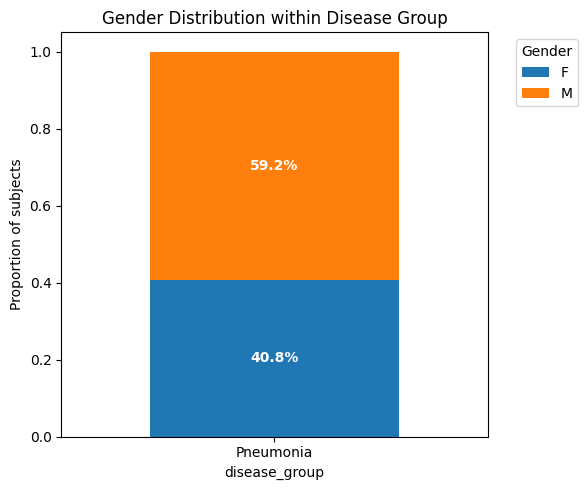

In [ ]:
gender_by_disease = pd.crosstab(
    df_ans['disease_group'],
    df_ans['gender'],
    values=df_ans['subjects_in_group'],
    aggfunc='sum'
).fillna(0)

# Calculate percentages
gender_by_disease_pct = gender_by_disease.div(
    gender_by_disease.sum(axis=1), axis=0
)
fig, ax = plt.subplots(figsize=(6, 5))
gender_by_disease_pct.plot(kind='bar', stacked=True, ax=ax, width=0.7)

# Add Percentage Labels
for c in ax.containers:
    # Create custom labels: format as %, hide if < 5% to avoid clutter
    labels = [f'{v.get_height()*100:.1f}%' if v.get_height() > 0.05 else '' for v in c]

    # Add labels to the center of the bars
    ax.bar_label(c, labels=labels, label_type='center', fontsize=10, color='white', weight='bold')

# Styling
plt.ylabel('Proportion of subjects')
plt.title('Gender Distribution within Disease Group')
plt.legend(title='Gender', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

#### Race Distributions

In [ ]:
race_by_disease = pd.crosstab(
    df_ans['disease_group'],
    df_ans['race_group'],
    values=df_ans['subjects_in_group'],
    aggfunc='sum'
).fillna(0)

race_by_disease_pct = race_by_disease.div(
    race_by_disease.sum(axis=1), axis=0
) * 100


#### Liver Disease

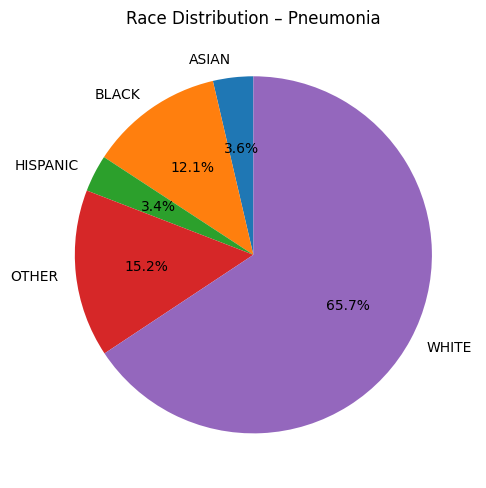

In [ ]:
disease = 'Pneumonia'
data = race_by_disease_pct.loc[disease]
data = data[data > 0]

plt.figure(figsize=(5,5))
plt.pie(
    data,
    labels=data.index,
    autopct='%.1f%%',
    startangle=90
)
plt.title(f'Race Distribution – {disease}')
plt.tight_layout()
plt.show()

#### Age Distribution

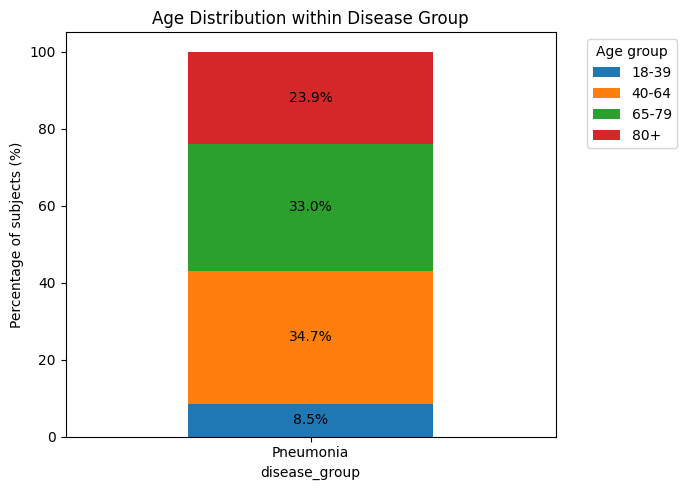

In [ ]:
age_by_disease = pd.crosstab(
    df_ans['disease_group'],
    df_ans['age_group'],
    values=df_ans['subjects_in_group'],
    aggfunc='sum'
).fillna(0)

age_by_disease_pct = age_by_disease.div(
    age_by_disease.sum(axis=1), axis=0
) * 100

fig, ax = plt.subplots(figsize=(7, 5))
age_by_disease_pct.plot(kind='bar', stacked=True, ax=ax)

ax.set_ylabel('Percentage of subjects (%)')
ax.set_title('Age Distribution within Disease Group')
ax.legend(title='Age group', bbox_to_anchor=(1.05, 1), loc='upper left')

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='center')

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


#### Language Distribution

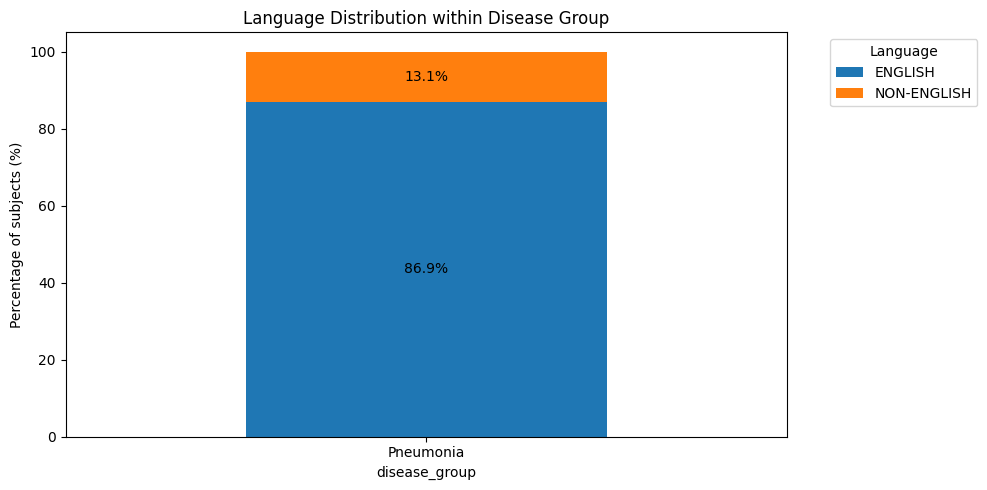

In [ ]:
# table: disease_group x language_group
lang_by_disease = pd.crosstab(
    df_ans['disease_group'],
    df_ans['language_group'],
    values=df_ans['subjects_in_group'],
    aggfunc='sum'
).fillna(0)

lang_by_disease_pct = lang_by_disease.div(
    lang_by_disease.sum(axis=1), axis=0
) * 100

fig, ax = plt.subplots(figsize=(10, 5))
lang_by_disease_pct.plot(kind='bar', stacked=True, ax=ax)

ax.set_ylabel('Percentage of subjects (%)')
ax.set_title('Language Distribution within Disease Group')
ax.legend(title='Language', bbox_to_anchor=(1.05, 1), loc='upper left')

# add % labels on each stacked segment
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='center')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


#### Marital Status Distribution

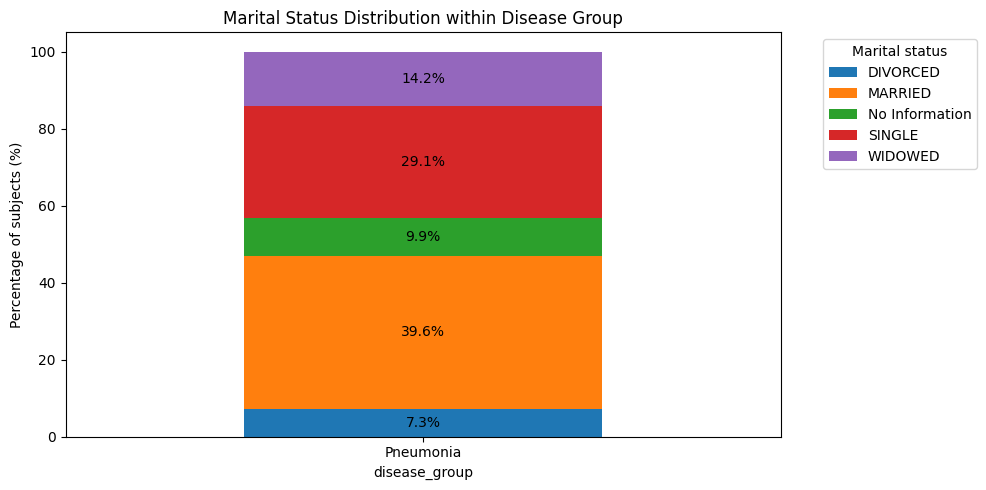

In [ ]:

df_ans['marital_status'] = df_ans['marital_status'].fillna("No Information")
df_ans['marital_status'] = df_ans['marital_status'].replace({"None": "No Information"})

mar_by_disease = pd.crosstab(
    df_ans['disease_group'],
    df_ans['marital_status'],
    values=df_ans['subjects_in_group'],
    aggfunc='sum'
).fillna(0)

mar_by_disease_pct = mar_by_disease.div(
    mar_by_disease.sum(axis=1), axis=0
) * 100

fig, ax = plt.subplots(figsize=(10, 5))
mar_by_disease_pct.plot(kind='bar', stacked=True, ax=ax)

ax.set_ylabel('Percentage of subjects (%)')
ax.set_title('Marital Status Distribution within Disease Group')
ax.legend(title='Marital status', bbox_to_anchor=(1.05, 1), loc='upper left')

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='center')

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

